# Segunda Preentrega - Trabajo Final - Bivanco Walter

## Dataset: Contagiados COVID 19 - Temática: Salud 

Enlace a la presentación del trabajo:
https://docs.google.com/presentation/d/1ad-RdzIA0VNQvnqFSgn6oPPmbH_FEyZHYjWv6K8j2WY/edit?usp=sharing

El repositorio con los datasets y notebooks que se van a utilizar en el proyecto final del curso estan ubicados en:* https://github.com/wbivanco/ds_coderhouse.git

## Introducción

### Objetivo

Con los datos históricos que se posee acerca de los contagiados en la República Argentina, ¿hay indicios que demuestren que hay alguna correlación entre alguna de las variables y el fallecimiento de un contagiado?

### Contexto del negocio

El año 2019 comenzaron los contagios de COVID-19, al momento que la misma se convirtió en un pandemia paso a ser un tema de suma importancia para los paises, apartir de ese instante se comenzó a llevar registro de los contagios, en el caso particular de la Argentina, toda esa información fue administrada por el gobierno nacional atraves de un sistema de carga de esa data. Dichos datos fueron disponibilizados para que el público en general pueda acceder y descargar los mismos.

### Problema del negocio

A la información recavada por parte del gobierno nacional se la pretende poder utilizar para poder llevar a cabo la toma de decisiones estratégicas.

### Contexto analítico

El dataset que es utilizado en el notebook tiene como temática la salud, el mismo fué descargado de https://www.datos.gob.ar que es el sitio oficial del gobierno de la República Argentina. Dentro del sitio luego de un análisis se decidio descargar la información de los contagiados de la Republica Argentina. Es un único archivo en formato CSV.

### Abstract:

El dataset almacena el listado de los contagiados de COVID-19 en la República Argentina desde el 01/03/2020 hasta el 04/06/2022, dicho dataset tiene una cantidad de 105.916.221 registros de los cuales seleccione los primeros 100.000 registros por lo tanto hay variables como las fechas que solo muestran un periodo muy corto.

El dataset lleva el registro de los contagios de COVID-19 que se produjeron en Argentina, dentro de información de maneja se puede mencionar que posee 17 campos entre los que se destacan los siguientes:

- id_evento_caso = es el número de caso, debido a que solo trabajamos con una parte de datasets, no será información muy útil.
- sexo
- edad
- residencia_provincia_nombre = es la provincia de residencia de la persona, aquí hay que aclarar que Buenos Aires y CABA pertenecen a la misma provincia que es Buenos Aires, pero hacen la diferencia entre interior(Buenos Aires) y capital(CABA).
- origen_financiamiento = indica si el análisis clínico fue realizado en la parte pública o privada.
- residencia_departemento_nombre = me indica el departamento de residencia de la persona cargado; este es un campo que no se tiene mucho en cuenta por que tiene mucha información sucia, como datos sin especificar, valores ficticios, etc.
- Hay casos de datos de tipos fecha que tienen muchos registros no cargados, como fecha_inicio_sintomas o fecha de fallecimiento, en este último caso evidencian que son para las personas que no han fallecido por causas del COVID-19.



## Configuraciones iniciales

### Librerías necesarias a tener instaladas en el entorno virtual para el correcto funcionamiento del notebook.

In [ ]:
# Librería que me permite tener una idea de los porcentajes de los campos que poseen nulos
!pip install missingno

# librería que permite graficar la matríz de confusión
!pip install scikit-plot

# Librería para hacer el profiling
!pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip 
    
# Librería para balanceo de variables(oversampling)
!pip install imbalanced-learn

# Librería para conectarse a Google Trends
!pip install pytrends

  Using cached https://github.com/pandas-profiling/pandas-profiling/archive/master.zip


  Created wheel for pytrends: filename=pytrends-4.8.0-py3-none-any.whl size=16126 sha256=2a0c7ac4e3ee4a92ef0126d9e75ff551253f1a98c7832794b7610ab5fe6a4b9e
  Stored in directory: /home/walter/.cache/pip/wheels/87/a9/a3/c190a7e0872639762e92cf3a84d6845ed086e10966533faf42
Successfully built pytrends


### Importación de librerías

In [ ]:
# Librerías gráficas
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Librería para visualización de nulos
import missingno as msno

# Libreria gráfica para la matríz de confusión
import scikitplot as skplt

# Librerías standard
import pandas as pd
import numpy as np

# Librerías para encoding de variables
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder

# Librería para hace un perfil del dataset
from pandas_profiling import ProfileReport

# Librerías para hacer balanceo del dataset
from imblearn.over_sampling import RandomOverSampler

# Librerías para algoritmos
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree

# Librería para uso estadístico
from scipy import stats

# Librería de test de Chi cuadrado
from scipy.stats import chi2_contingency

# Librería para utilizar Google Trends
from pytrends.request import TrendReq

# Librería para el cálculo de MAD (desviación media absoluta)
from numpy import mean, absolute

# Librerías para métricas
from sklearn.metrics import accuracy_score, classification_report
#from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, classification_report

# Librería para modelos de selección de características
import statsmodels.api as sm

### Funciones a utilizar

La idea es que estas funciones puedan ser importadas desde un archivo externo, dicho archivo tendría la función de librería de utilidades propias y que pueden ser utilizadas en otros notebooks.

In [ ]:
# Si se coloca en un archivo separado las funciones de más abajo, se deben importar las siguientes librerías
#import numpy as np
#import pandas as pd
#import statsmodels.api as sm


# Gráficos
def formatear_autopct(values):
    """
    Permite agregar al piechart, info de la cantidad en número de cada porción del piechart, no solo los 
    porcentajes.
    """
    def my_format(pct):
        total = sum(values)        
        val = int(round(pct*total/100.0))
        return '{:.1f}%\n({v:d})'.format(pct, v=val)
    return my_format


# Cálculos
def calcular_mad(data, axis=None):
    """
    Calcula la desviación absoluta media.
    """
    return mean(absolute(data - mean(data, axis)), axis)


# Imputaciones
def imputar_outliers_IQR(df):
    """
    Se crea una función que permite aplicar el criterio de reemplazo de atípicos. Se reemplaza el
    atípico por la mediana que es una medida robusta(no influenciada por outliers). 
    Recibe un dataframe con las columnas a imputar.
    """
    q1 = df.quantile(0.25)
    q3 = df.quantile(0.75)
    IQR = q3-q1
    upper = df[~(df>(q3+1.5*IQR))].max()
    lower = df[~(df<(q1-1.5*IQR))].min()
    df = np.where(df>upper, df.median(), np.where(df<lower, df.median(), df))
    return df


# Selección de características
def forward_selection(data, target, significance_level=0.01):
    """
    Se declara función del método forward para la selección de características.
    """
    initial_features = data.columns.tolist()
    best_features = []
    
    while (len(initial_features) > 0):
        remaining_features = list(set(initial_features) - set(best_features))
        new_pval = pd.Series(index=remaining_features)
        
        for new_column in remaining_features:
            model = sm.OLS(target, sm.add_constant(data[best_features+[new_column]])).fit()
            new_pval[new_column] = model.pvalues[new_column]
        min_p_value = new_pval.min()
        
        if(min_p_value < significance_level):
            best_features.append(new_pval.idxmin())
        else:
            break
            
    return best_features


## Data acquisition
En una primera instancia se va llevar a cabo un análisis inicial del dataset para tener una panorama general de la data que maneja.

Se obtiene el dataset desde un archivo almacenado en Google Drive.

In [ ]:
url = 'https://docs.google.com/spreadsheets/d/1Y1XbymFFNfLCdTjDT64oIMVw1YE4x5TdlzK2eyCWoDM/export?format=csv&gid=1022416023'

df = pd.read_csv(url)

df.head()

id_evento_caso sexo  edad edad_años_meses residencia_pais_nombre  \
0         1000000    M  55.0            Años              Argentina   
1        10000000    F  53.0            Años              Argentina   
2        10000001    F  23.0            Años              Argentina   
3        10000002    F  45.0            Años              Argentina   
4        10000003    F  34.0            Años              Argentina   

  residencia_provincia_nombre residencia_departamento_nombre  \
0                        CABA                SIN ESPECIFICAR   
1                        CABA                SIN ESPECIFICAR   
2                Buenos Aires                Lomas de Zamora   
3                Buenos Aires                     La Matanza   
4                        CABA                      COMUNA 01   

  carga_provincia_nombre fecha_inicio_sintomas fecha_apertura  ...  \
0           Buenos Aires                   NaN     2020-06-01  ...   
1                   CABA                   NaN     2021-04-08  ...   
2           Buenos Aires            2021-04-05     2021-04-08  ...   
3                   CABA                   NaN     2021-04-08  ...   
4                   CABA                   NaN     2021-04-08  ...   

   fecha_fallecimiento asistencia_respiratoria_mecanica carga_provincia_id  \
0                  NaN                               NO                  6   
1                  NaN                               NO                  2   
2                  NaN                               NO                  6   
3                  NaN                               NO                  2   
4                  NaN                               NO                  2   

  origen_financiamiento    clasificacion clasificacion_resumen  \
0               Privado  Caso Descartado            Descartado   
1               Público  Caso Descartado            Descartado   
2               Público  Caso Descartado            Descartado   
3               Público  Caso Descartado            Descartado   
4               Público  Caso Descartado            Descartado   

  residencia_provincia_id  fecha_diagnostico residencia_departamento_id  \
0                       2         2020-06-09                          0   
1                       2         2021-04-08                          0   
2                       6         2021-04-08                        490   
3                       6         2021-04-06                        427   
4                       2         2021-04-08                          1   

  ultima_actualizacion  
0           2022-06-05  
1           2022-06-05  
2           2022-06-05  
3           2022-06-05  
4           2022-06-05  

[5 rows x 25 columns]

In [ ]:
df.shape

(100000, 25)

In [ ]:
df.columns

Index(['id_evento_caso', 'sexo', 'edad', 'edad_años_meses',
       'residencia_pais_nombre', 'residencia_provincia_nombre',
       'residencia_departamento_nombre', 'carga_provincia_nombre',
       'fecha_inicio_sintomas', 'fecha_apertura', 'sepi_apertura',
       'fecha_internacion', 'cuidado_intensivo', 'fecha_cui_intensivo',
       'fallecido', 'fecha_fallecimiento', 'asistencia_respiratoria_mecanica',
       'carga_provincia_id', 'origen_financiamiento', 'clasificacion',
       'clasificacion_resumen', 'residencia_provincia_id', 'fecha_diagnostico',
       'residencia_departamento_id', 'ultima_actualizacion'],
      dtype='object')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 25 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   id_evento_caso                    100000 non-null  int64  
 1   sexo                              100000 non-null  object 
 2   edad                              99970 non-null   float64
 3   edad_años_meses                   100000 non-null  object 
 4   residencia_pais_nombre            100000 non-null  object 
 5   residencia_provincia_nombre       100000 non-null  object 
 6   residencia_departamento_nombre    100000 non-null  object 
 7   carga_provincia_nombre            100000 non-null  object 
 8   fecha_inicio_sintomas             36418 non-null   object 
 9   fecha_apertura                    100000 non-null  object 
 10  sepi_apertura                     100000 non-null  int64  
 11  fecha_internacion                 2658 non-null    ob

In [ ]:
df.describe()

id_evento_caso          edad  sepi_apertura  carga_provincia_id  \
count    1.000000e+05  99970.000000  100000.000000       100000.000000   
mean     9.375346e+06     38.579594      14.669870           22.348080   
std      2.373808e+06     17.447920       2.362236           28.592709   
min      1.000000e+06      1.000000      14.000000            2.000000   
25%      1.001848e+07     26.000000      14.000000            2.000000   
50%      1.004438e+07     37.000000      14.000000            6.000000   
75%      1.007070e+07     50.000000      14.000000           30.000000   
max      1.009716e+07    222.000000      23.000000           94.000000   

       residencia_provincia_id  residencia_departamento_id  
count            100000.000000                100000.00000  
mean                 23.366560                   204.02063  
std                  28.796844                   253.71888  
min                   2.000000                     0.00000  
25%                   6.000000                    14.00000  
50%                   6.000000                    84.00000  
75%                  34.000000                   410.00000  
max                  99.000000                   882.00000

Con la información obtenida tenemos una idea de cuales con los campos que maneja, de que tipo son, si existen nulos y los estadísticos de los campos numéricos.

## Data Wrangling

Terminado el EDA en donde se obtuvo una idea general de la información del dataset, se procede con el análisis de duplicacado, nulos y atípicos. Una vez terminado el análisis de cada uno de estos pasos, se procederá a la toma de decisiones para cada uno de los casos.

### Análisis de duplicados

Se verifica si existen duplicados.

In [ ]:
df.duplicated().unique()

array([False])

#### Decisión para duplicados:
Se observa que no existen duplicados por lo tanto no se lleva a cabo ninguna acción.

### Análisis de nulos

Para la verificación de aquellos campos que presentan nulos se lleva a cabo el cálculo de los porcentajes de los mismos con respecto al total. 

In [ ]:
por_nulos = (df.isnull().sum()/df.shape[0])*100

por_nulos = por_nulos.sort_values(ascending=False)

por_nulos = por_nulos[por_nulos>0]

por_nulos

fecha_cui_intensivo      99.486
fecha_fallecimiento      99.370
fecha_internacion        97.342
fecha_inicio_sintomas    63.582
fecha_diagnostico         6.311
edad                      0.030
dtype: float64

Para tener una idea más clara de los valores, es que se representa estos porcentajes por medio de un gráfico de barras.

<AxesSubplot:>

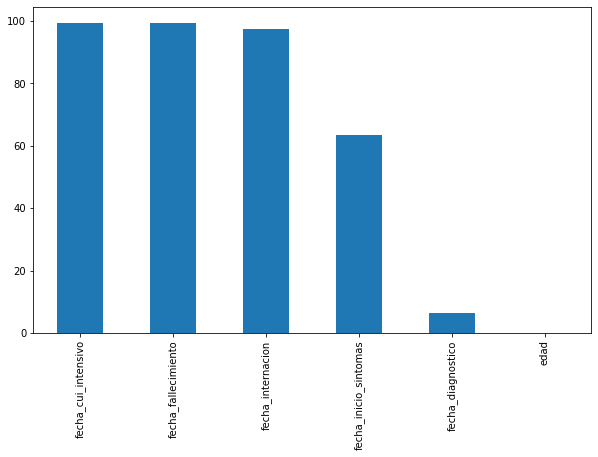

In [ ]:
plt.figure(figsize=(10, 6))

por_nulos.plot(kind='bar')

Gráfica los nulos del dataset.

<AxesSubplot:>

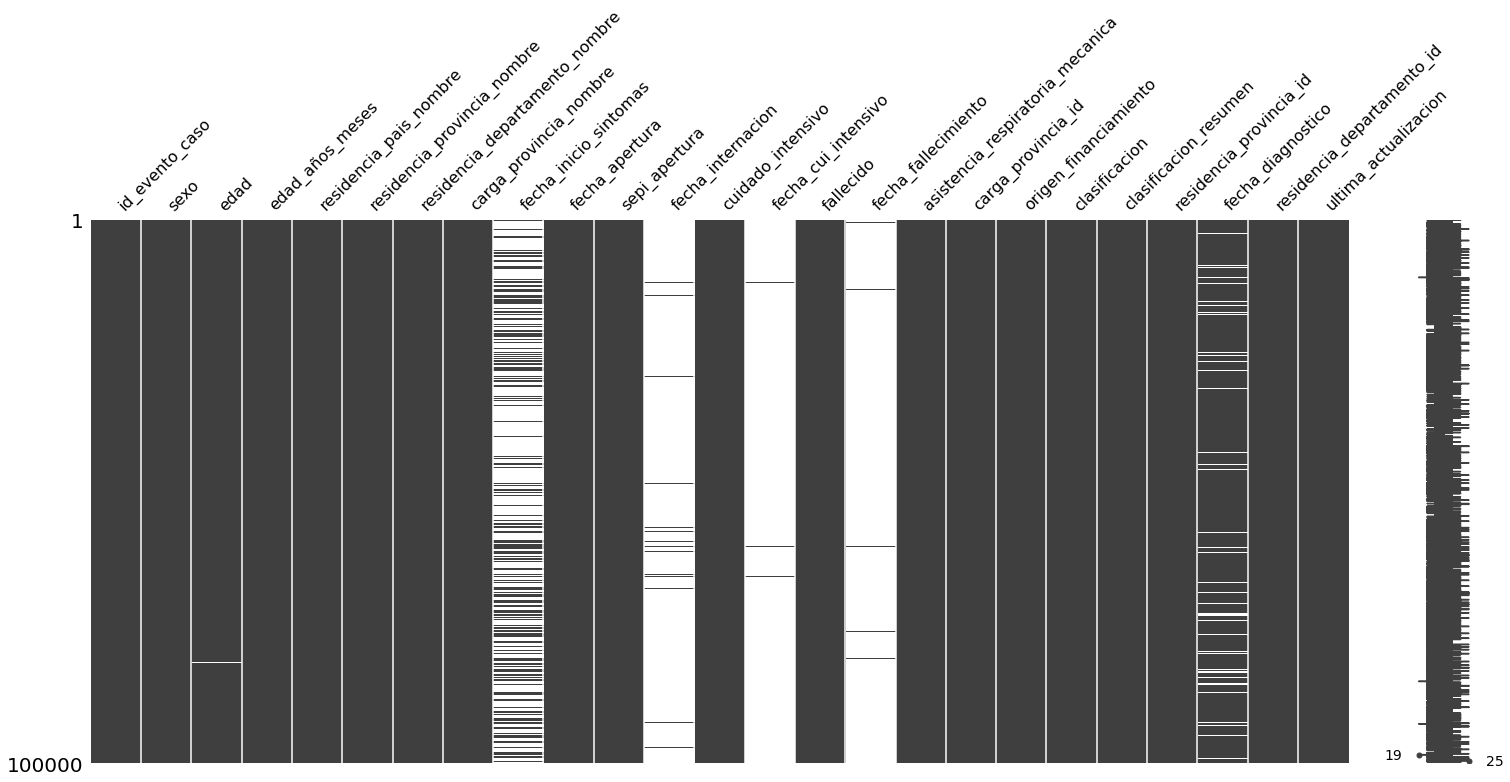

In [ ]:
msno.matrix(df)

Mapa de calor de correlación de variables.

<AxesSubplot:>

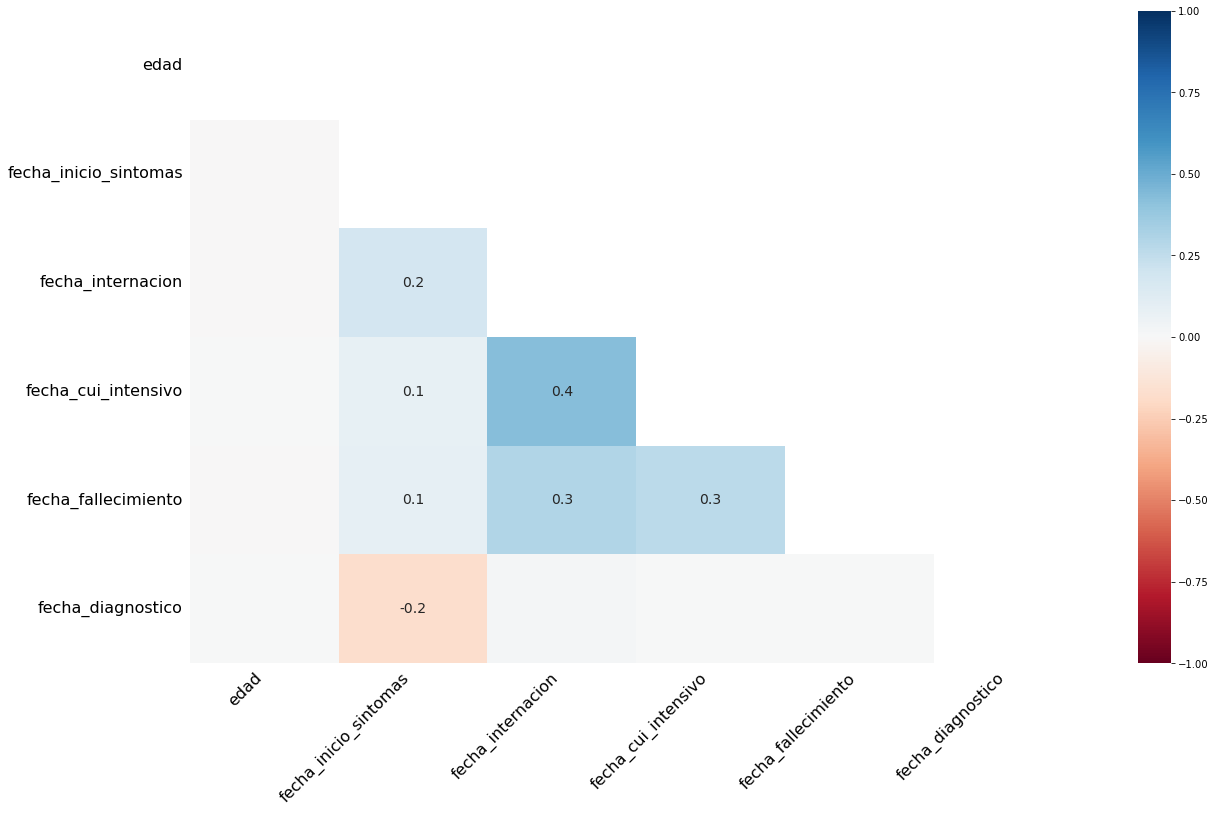

In [ ]:
msno.heatmap(df)

#### Decisión para nulos: 
* Las variables que poseen más del 60% de nulos se las elimina. 
* Para el caso de **fecha_diagnostico**, no posee muchos nulos pero no es de importancia en el caso se la elimina.
* Para la variable **edad** que posee pocos nulos se va a emplear alguna técnica de reemplazo. 

Columnas a borrar con muchos nulos.

In [ ]:
col_del = ['fecha_cui_intensivo', 'fecha_fallecimiento', 'fecha_internacion', 'fecha_inicio_sintomas', 'fecha_diagnostico'] 

df = df.drop(labels=col_del, axis=1) # Borrando las columnas en col_del

df.columns 

Index(['id_evento_caso', 'sexo', 'edad', 'edad_años_meses',
       'residencia_pais_nombre', 'residencia_provincia_nombre',
       'residencia_departamento_nombre', 'carga_provincia_nombre',
       'fecha_apertura', 'sepi_apertura', 'cuidado_intensivo', 'fallecido',
       'asistencia_respiratoria_mecanica', 'carga_provincia_id',
       'origen_financiamiento', 'clasificacion', 'clasificacion_resumen',
       'residencia_provincia_id', 'residencia_departamento_id',
       'ultima_actualizacion'],
      dtype='object')

In [ ]:
df.edad.value_counts()

31.0     2523
30.0     2516
29.0     2484
28.0     2411
27.0     2393
         ... 
122.0       2
104.0       2
100.0       2
111.0       1
102.0       1
Name: edad, Length: 107, dtype: int64

Columna **edad** con pocos nulos, se reemplaza por la mediana(ya que se observaron algunos outliers).

In [ ]:
df['edad'] = df['edad'].fillna(df['edad'].median())

Se verifica que el dataset no contenga nulos.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 20 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   id_evento_caso                    100000 non-null  int64  
 1   sexo                              100000 non-null  object 
 2   edad                              100000 non-null  float64
 3   edad_años_meses                   100000 non-null  object 
 4   residencia_pais_nombre            100000 non-null  object 
 5   residencia_provincia_nombre       100000 non-null  object 
 6   residencia_departamento_nombre    100000 non-null  object 
 7   carga_provincia_nombre            100000 non-null  object 
 8   fecha_apertura                    100000 non-null  object 
 9   sepi_apertura                     100000 non-null  int64  
 10  cuidado_intensivo                 100000 non-null  object 
 11  fallecido                         100000 non-null  ob

### Análisis de Outliers

Filtro solo las columnas que se numéricas.

In [ ]:
numericos = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

col_num = df.select_dtypes(include=numericos)

col_num.columns

Index(['id_evento_caso', 'edad', 'sepi_apertura', 'carga_provincia_id',
       'residencia_provincia_id', 'residencia_departamento_id'],
      dtype='object')

Elimino la columna **id_evento_caso** ya que no es de utilidad en el análisis que se está llevando acabo, además para que no ensucie los gráficos a que a continuación se muestran.

In [ ]:
col_num = col_num.drop('id_evento_caso', axis=1)

Gráfica de las variables numéricas con atípicos. 

<AxesSubplot:>

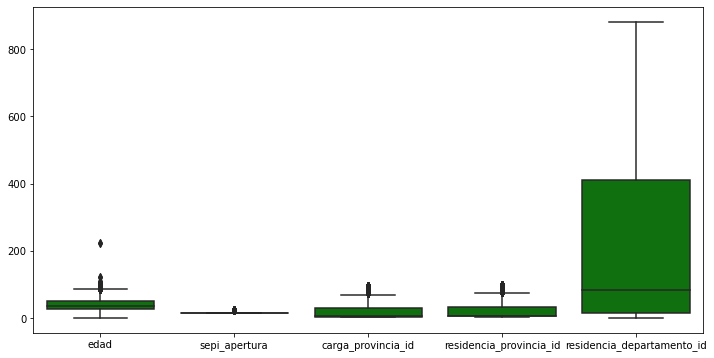

In [ ]:
plt.figure(figsize=(12, 6))

sns.boxplot(data=col_num, color='green' )

Gráfica de las variables numéricas sín atípicos. 

<AxesSubplot:>

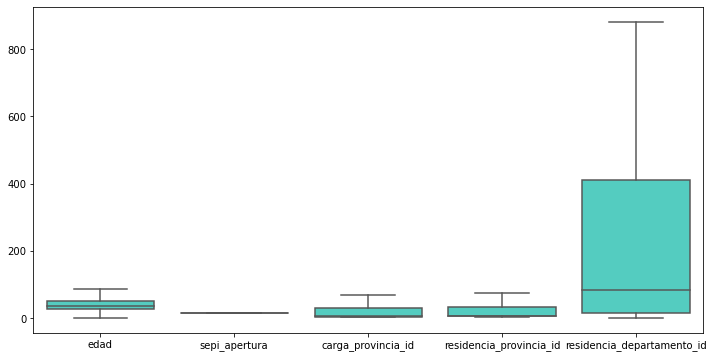

In [ ]:
plt.figure(figsize=(12, 6))

sns.boxplot(data=col_num, showfliers=False, color='turquoise')

#### Decisión para outliers:
Se va a lleavar a cabo la imputación de variables según el siguiente criterio:

* Si el valor de la variable es mayor al q3 o menor al q1, el mismo es reemplazado por la mediana.
* Si el valor de la variable esta dentro del rango intercuartílico(q3-q1) se conserva el mismo.

Imputo las columnas.

In [ ]:
columnas = col_num.columns

df[columnas] = imputar_outliers_IQR(df[columnas])

In [ ]:
df

id_evento_caso sexo  edad edad_años_meses residencia_pais_nombre  \
0             1000000    M  55.0            Años              Argentina   
1            10000000    F  53.0            Años              Argentina   
2            10000001    F  23.0            Años              Argentina   
3            10000002    F  45.0            Años              Argentina   
4            10000003    F  34.0            Años              Argentina   
...               ...  ...   ...             ...                    ...   
99995        10097151    F  14.0            Años              Argentina   
99996        10097152    F  38.0            Años              Argentina   
99997        10097153    M  30.0            Años              Argentina   
99998        10097154    M  31.0            Años              Argentina   
99999        10097155    M  16.0            Años        SIN ESPECIFICAR   

      residencia_provincia_nombre residencia_departamento_nombre  \
0                            CABA                SIN ESPECIFICAR   
1                            CABA                SIN ESPECIFICAR   
2                    Buenos Aires                Lomas de Zamora   
3                    Buenos Aires                     La Matanza   
4                            CABA                      COMUNA 01   
...                           ...                            ...   
99995                       Chaco                Almirante Brown   
99996                     Mendoza                     San Rafael   
99997                Buenos Aires                        Quilmes   
99998                Buenos Aires                          Lanús   
99999                    San Juan                      Rivadavia   

      carga_provincia_nombre fecha_apertura  sepi_apertura cuidado_intensivo  \
0               Buenos Aires     2020-06-01           14.0                NO   
1                       CABA     2021-04-08           14.0                NO   
2               Buenos Aires     2021-04-08           14.0                NO   
3                       CABA     2021-04-08           14.0                NO   
4                       CABA     2021-04-08           14.0                NO   
...                      ...            ...            ...               ...   
99995                  Chaco     2021-04-09           14.0                NO   
99996                Mendoza     2021-04-09           14.0                NO   
99997           Buenos Aires     2021-04-09           14.0                NO   
99998           Buenos Aires     2021-04-09           14.0                NO   
99999               San Juan     2021-04-09           14.0                NO   

      fallecido asistencia_respiratoria_mecanica  carga_provincia_id  \
0            NO                               NO                 6.0   
1            NO                               NO                 2.0   
2            NO                               NO                 6.0   
3            NO                               NO                 2.0   
4            NO                               NO                 2.0   
...         ...                              ...                 ...   
99995        NO                               NO                22.0   
99996        NO                               NO                50.0   
99997        NO                               NO                 6.0   
99998        NO                               NO                 6.0   
99999        NO                               NO                70.0   

      origen_financiamiento  \
0                   Privado   
1                   Público   
2                   Público   
3                   Público   
4                   Público   
...                     ...   
99995               Público   
99996               Privado   
99997               Público   
99998               Privado   
99999               Público   

                                           clasificacion  \
0                             

### Resultado Data Wrangling
Con la aplicación de las distintas técnicas, se logró tener un dataset limpio de duplicados, nulos y atípicos. 
A continuación se procede a realizar otro EDA que me permita responder preguntas de interés.

## EDA

En primer lugar se va hacer un profiling de los datos

In [ ]:
profile = ProfileReport(df, title='Resumen COVID-19')

profile.to_notebook_iframe()

#profile.to_widgets()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### Pregunta / Hipótesis 1
* Hay más mujeres que hombres que se contagiaron de covid en el periodo seleccionado.

#### Proporción de contagios por sexo

In [ ]:
discriminado_por_sexo = df.groupby("sexo").count()

discriminado_por_sexo

id_evento_caso   edad  edad_años_meses  residencia_pais_nombre  \
sexo                                                                   
F              52663  52663            52663                   52663   
M              46595  46595            46595                   46595   
NR               742    742              742                     742   

      residencia_provincia_nombre  residencia_departamento_nombre  \
sexo                                                                
F                           52663                           52663   
M                           46595                           46595   
NR                            742                             742   

      carga_provincia_nombre  fecha_apertura  sepi_apertura  \
sexo                                                          
F                      52663           52663          52663   
M                      46595           46595          46595   
NR                       742             742            742   

      cuidado_intensivo  fallecido  asistencia_respiratoria_mecanica  \
sexo                                                                   
F                 52663      52663                             52663   
M                 46595      46595                             46595   
NR                  742        742                               742   

      carga_provincia_id  origen_financiamiento  clasificacion  \
sexo                                                             
F                  52663                  52663          52663   
M                  46595                  46595          46595   
NR                   742                    742            742   

      clasificacion_resumen  residencia_provincia_id  \
sexo                                                   
F                     52663                    52663   
M                     46595                    46595   
NR                      742                      742   

      residencia_departamento_id  ultima_actualizacion  
sexo                                                    
F                          52663                 52663  
M                          46595                 46595  
NR                           742                   742

Text(0.5, 1.0, 'Cantidas de contagiados por sexo')

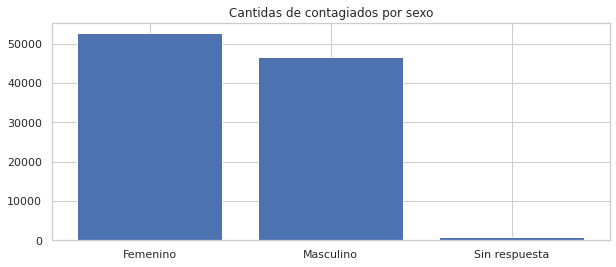

In [ ]:
discriminado_por_sexo_id = discriminado_por_sexo.id_evento_caso

fig, ax = plt.subplots(figsize=(10, 4))

etiquetas = ["Femenino", "Masculino", "Sin respuesta"]

ax.bar(discriminado_por_sexo_id.index, discriminado_por_sexo_id.values, tick_label=etiquetas) 

plt.title('Cantidas de contagiados por sexo')

Se observa que hay mas contagios del sexo femenino pero la deferencia no es tan grande.

### Pregunta / Hipótesis 2
* Se desea saber cómo es la proporción de contagios con respecto a las provincias.

#### Proporción de contagios por provincia de residencia

Primeramente se agrupa por provincia y se cuenta los casos de cada provincia, luego se selecciona la a analizar y por último se ordena la serie en forma descendente.

In [ ]:
total_por_provincia_todos = df.groupby("residencia_provincia_nombre").count()

total_por_provincia = total_por_provincia_todos.id_evento_caso

total_por_provincia = total_por_provincia.sort_values(ascending=False)

Se grafica los datos obtenidos pero esta vez utilizando Plotly

In [ ]:
fig = px.bar(total_por_provincia, x=total_por_provincia.index, y=total_por_provincia.values, 
             title="Cantidad de contagios por provincia", labels={'residencia_provincia_nombre': 'Provincia', 
            'y': 'Cantidad de contagios'}, text_auto = True)

fig.update_traces(textfont_size = 14, textangle = 0, textposition = "outside")

fig.show()

Se observa que una provincia(Buenos aires + CABA) tiene mas del 50% de los contagios del pais, es razonables ya que son los lugares más densamente poblados. Ademá hay información que se solapa y no queda legible en el gráfico.

### Pregunta / Hipótesis 3
* Se desea conocer si hay una región del pais que posee mas contagios que las otras.

#### Cantidad de contagios por región

Para tener un panorama mas macro se procede a agrupar provincias según su región para hacer una comparativa entre las mismas.

In [ ]:
# Se crean los arrays con las regiones
noa = ['Catamarca', 'Jujuy', 'Tucumán', 'Salta', 'Santiago del Estero']
nea = ['Chaco', 'Formosa', 'Corrientes', 'Misiones']
cuyo = ['Mendoza', 'San Luis', 'San Juan', 'La Rioja']
centro = ['Buenos Aires', 'CABA', 'Córdoba', 'Santa Fe', 'Entre Ríos']
patagonia = ['La Pampa', 'Chubut', 'Santa Cruz', 'Río Negro', 'Neuquén', 'Tierra del Fuego']
 
# Se convierte la serie a data frame
tpp = pd.DataFrame(total_por_provincia)

# Se pasa el índice como una columna del dataframe
tpp['provincia'] = tpp.index
tpp['sexo'] = df['sexo']
#tpp.reset_index(drop=True, inplace=True)

# Se crea la columna región y se coloca un valor por defecto 
tpp = tpp.assign(region="Sin Especificar")

# Se reemplaza la columna region con la región correspondiente según la provincia
for prov in tpp['provincia']:
    for pr in noa:
        if prov == pr:
            tpp.loc[prov, 'region'] = 'Noa'

for prov in tpp['provincia']:
    for pr in nea:
        if prov == pr:
            tpp.loc[prov, 'region'] = 'Nea'

for prov in tpp['provincia']:
    for pr in centro:
        if prov == pr:
            tpp.loc[prov, 'region'] = 'Centro'
            
for prov in tpp['provincia']:
    for pr in cuyo:
        if prov == pr:
            tpp.loc[prov, 'region'] = 'Cuyo'
            
for prov in tpp['provincia']:
    for pr in patagonia:
        if prov == pr:
            tpp.loc[prov, 'region'] = 'Patagonia'

tpp

id_evento_caso            provincia sexo  \
residencia_provincia_nombre                                             
Buenos Aires                          38402         Buenos Aires  NaN   
CABA                                  18661                 CABA  NaN   
Córdoba                                9700              Córdoba  NaN   
Santa Fe                               4807             Santa Fe  NaN   
Mendoza                                4097              Mendoza  NaN   
Tucumán                                3934              Tucumán  NaN   
San Luis                               3245             San Luis  NaN   
Corrientes                             3054           Corrientes  NaN   
Chaco                                  1646                Chaco  NaN   
Entre Ríos                             1319           Entre Ríos  NaN   
Salta                                  1297                Salta  NaN   
La Pampa                               1197             La Pampa  NaN   
Chubut                                  967               Chubut  NaN   
San Juan                                952             San Juan  NaN   
Santa Cruz                              889           Santa Cruz  NaN   
Santiago del Estero                     885  Santiago del Estero  NaN   
Formosa                                 881              Formosa  NaN   
Río Negro                               810            Río Negro  NaN   
Catamarca                               757            Catamarca  NaN   
Neuquén                                 699              Neuquén  NaN   
La Rioja                                510             La Rioja  NaN   
Jujuy                                   396                Jujuy  NaN   
Misiones                                396             Misiones  NaN   
Tierra del Fuego                        307     Tierra del Fuego  NaN   
SIN ESPECIFICAR                         192      SIN ESPECIFICAR  NaN   

                                      region  
residencia_provincia_nombre                   
Buenos Aires                          Centro  
CABA                                  Centro  
Córdoba                               Centro  
Santa Fe                              Centro  
Mendoza                                 Cuyo  
Tucumán                                  Noa  
San Luis                                Cuyo  
Corrientes                               Nea  
Chaco                                    Nea  
Entre Ríos                            Centro  
Salta                                    Noa  
La Pampa                           Patagonia  
Chubut                             Patagonia  
San Juan                                Cuyo  
Santa Cruz                         Patagonia  
Santiago del Estero                      Noa  
Formosa                                  Nea  
Río Negro                          Patagonia  
Catamarca                                Noa  
Neuquén                            Patagonia  
La Rioja                                Cuyo  
Jujuy                                    Noa  
Misiones                                 Nea  
Tierra del Fuego                   Patagonia  
SIN ESPECIFICAR              Sin Especificar

Agrupo por región y sumo la cantidad de contagios.

In [ ]:
tpp = tpp.groupby('region').sum()

tpp = tpp.rename(columns={'id_evento_caso':'cantidad de casos'})

tpp

cantidad de casos
region                            
Centro                       72889
Cuyo                          8804
Nea                           5977
Noa                           7269
Patagonia                     4869
Sin Especificar                192

Text(0, 0.5, 'Cantidad')

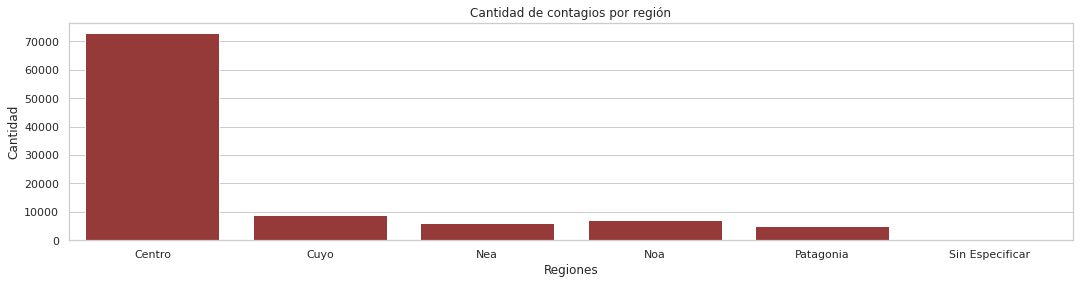

In [ ]:
# Se grafican los resultados obtenidos
sns.set_theme(style="whitegrid")

f, axs = plt.subplots(nrows=1, ncols=1, figsize=(18, 4))

ax = sns.barplot(x=tpp.index, y=tpp["cantidad de casos"], data=tpp, color='brown').set(title='Cantidad de contagios por región')

plt.xlabel("Regiones")

plt.ylabel("Cantidad")

Se observa en la gráfica que la región con más contagios es la centro, es bastante razonables ésto ya que en esa región se encuentran las provincias mas pobladas.

### Consumo de API de Google Trends
Se consulta la API de Google Trends de la presente fecha a un año atrás, para ver que información de utilidad se puede obtener.  

In [ ]:
pytrends = TrendReq(hl="es")

# Se establece una variable lista que incluya la palabra o palabras que queremos analizar
lista_palabras = ["covid", "coronavirus", "covid-19", "covid19", "pandemia"]
   
# Se pasa todos los parámetros que se desea a la solicitud (filtrado)
pytrends.build_payload(lista_palabras, cat=0, timeframe="today 12-m", geo="ES")
     
# Se ejecuta la consulta
api = pytrends.interest_over_time()

api

covid  coronavirus  covid-19  covid19  pandemia  isPartial
date                                                                  
2021-10-31     13            6         0        0         0      False
2021-11-07     15            6         0        0         0      False
2021-11-14     25            7         1        0         0      False
2021-11-21     39            8         1        0         0      False
2021-11-28     56            9         1        0         0      False
2021-12-05     52            9         1        0         0      False
2021-12-12     62           10         1        0         0      False
2021-12-19    100           15         1        0         1      False
2021-12-26     82           15         1        0         1      False
2022-01-02     63           12         1        0         1      False
2022-01-09     57           11         1        0         1      False
2022-01-16     48            9         1        0         1      False
2022-01-23     40            7         1        0         1      False
2022-01-30     30            6         0        0         1      False
2022-02-06     25            5         0        0         0      False
2022-02-13     20            5         0        0         0      False
2022-02-20     16            4         0        0         0      False
2022-02-27     15            4         0        0         0      False
2022-03-06     14            3         0        0         0      False
2022-03-13     14            3         0        0         0      False
2022-03-20     13            3         0        0         0      False
2022-03-27     12            3         0        0         0      False
2022-04-03     12            2         0        0         0      False
2022-04-10     11            2         0        0         0      False
2022-04-17     13            2         0        0         0      False
2022-04-24     13            2         0        0         0      False
2022-05-01     13            2         0        0         0      False
2022-05-08     13            2         0        0         0      False
2022-05-15     12            2         0        0         0      False
2022-05-22      9            1         0        0         0      False
2022-05-29      9            1         0        0         0      False
2022-06-05      9            1         0        0         0      False
2022-06-12     11            1         0        0         0      False
2022-06-19     13            2         0        0         0      False
2022-06-26     16            2         0        0         0      False
2022-07-03     16            2         0        0         0      False
2022-07-10     13            2         0        0         0      False
2022-07-17     10            1         0        0         0      False
2022-07-24      8            1         0        0         0      False
2022-07-31      7            1         0        0         0      False
2022-08-07      5            1         0        0         0      False
2022-08-14      5            1         0        0         0      False
2022-08-21      4            1         0        0         0      False
2022-08-28      4            1         0        0         0      False
2022-09-04      4            1         0        0         0      False
2022-09-11      4            1         0        0         0      False
2022-09-18      4            1         0        0         0      False
2022-09-25      4            1         0        0         0      False
2022-10-02      4            1         0        0         0      False
2022-10-09      4            1         0        0         0      False
2022-10-16      5            1         0        0         0      False
2022-10-23      5            1         0        0         0       True

In [ ]:
# Se elimina de dataframe la columna isPartial que no es numérica y que no aporta al análisis que se desea realizar.
api = api.drop("isPartial", axis=1)

In [ ]:
fig = px.line(api, x=api.index, y=api.columns, title='Cantidad de consultas referidas a COVID-19 en Google Trends')

fig.update_layout(xaxis_title="Fechas", yaxis_title="Cantidad de consultas", legend_title="Términos",
    font = dict(
        family="Courier New, monospace",
        size=18,
        color="RebeccaPurple"
    )
)

fig.show()

Las consultas realizadas a Google Trends varia de acuerdo al termino consultado, se puede apreciar que covid es el termino más buscado, pero se ve que tuvo un pico entre fines del 2021.

## Análisis estadístico

### Análisis Univariado

Retomando el resultado de profiling se puede observar que a la variable edad se le puede llevar a cabo un análisis univariado.

<AxesSubplot:xlabel='edad'>

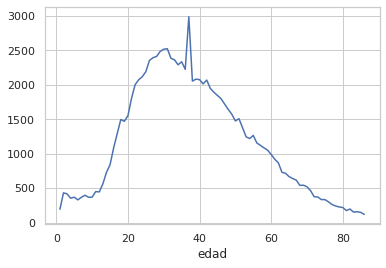

In [ ]:
edad_agrupada = df.groupby(df['edad']).size()

edad_agrupada.plot.line()

Se observa que el pico de la edad de los contagiados se da cerca de los 40 años.

#### Medidas de tendencia central

In [ ]:
stats.describe(df['edad'])

DescribeResult(nobs=100000, minmax=(1.0, 86.0), mean=38.14505, variance=281.42210471854713, skewness=0.36911672801823125, kurtosis=-0.21298482695446186)

In [ ]:
# Media geométrica
stats.gmean(df['edad'])

33.61418141777926

In [ ]:
# Media armónica
stats.hmean(df['edad']) 

25.81816768667241

In [ ]:
# Media recortada (Proporción removida en cada cola 10%)
stats.trim_mean(df['edad'], 0.1) 

37.439625

In [ ]:
# Moda
stats.mode(df['edad']) 

ModeResult(mode=array([37.]), count=array([2987]))

#### Medidas de localización

In [ ]:
np.percentile(df['edad'], [25, 75, 90])

array([26., 49., 61.])

In [ ]:
# Cuartiles
np.percentile(df['edad'], [0, 25, 75, 100]) 

array([ 1., 26., 49., 86.])

In [ ]:
# Deciles
np.percentile(df['edad'], [np.arange(0, 100, 10)]) 

array([[ 1., 18., 24., 28., 32., 37., 41., 46., 52., 61.]])

#### Medidas de disperción absolutas

In [ ]:
# Varianza
stats.describe(df['edad'])[3] 

281.42210471854713

In [ ]:
# Desviación standard
np.sqrt(stats.describe(df['edad'])[3]) 

16.77564021784406

In [ ]:
# Rango intercuartilico
stats.iqr(df['edad']) 

23.0

In [ ]:
# Desviación del cuartíl
(np.percentile(df['edad'], 75)-np.percentile(df['edad'], 25))/2 

11.5

In [ ]:
# Desviación absoluta media
calcular_mad(df['edad']) 

13.522721416000506

#### Medidas de disperción relativas

In [ ]:
# Coeficiente de variación (CV)
stats.variation(df['edad']) 

0.4397833097461735

In [ ]:
# Coeficiente de variación de la desviación del cuartíl
(np.percentile(df['edad'], 75)-np.percentile(df['edad'], 25))/(np.percentile(df['edad'], 75)+np.percentile(df['edad'], 25)) 

0.30666666666666664

In [ ]:
# Error estandar
stats.sem(df['edad']) 

0.05304923229591047

#### Asimetría y Curtosis

In [ ]:
# Asimetría
stats.skew(df['edad']) 

0.36911672801823125

In [ ]:
# Curtosis
stats.kurtosis(df['edad'])-3 

-3.212984826954462

(array([ 5057., 18644., 29262., 22706., 14410.,  7053.,  2868.]),
 array([ 1.        , 13.14285714, 25.28571429, 37.42857143, 49.57142857,
        61.71428571, 73.85714286, 86.        ]),
 <BarContainer object of 7 artists>)

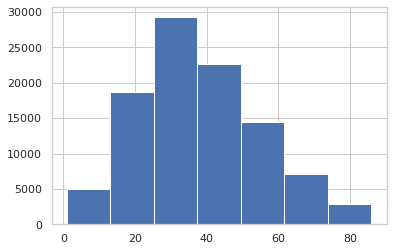

In [ ]:
plt.hist(df['edad'], bins=7)

Aquí se puede observar que la edad posee una distribución normal con una pequeña asimetría a derecha(positiva).

### Análisis Bivariado

#### Dependencias numéricas vs  numéricas

Se va a utilizar la correlación de Pearson, luego para poder tener una mejor visión de los valores obtenidos se va a graficar las correlaciones con un mapa de calor.

<AxesSubplot:>

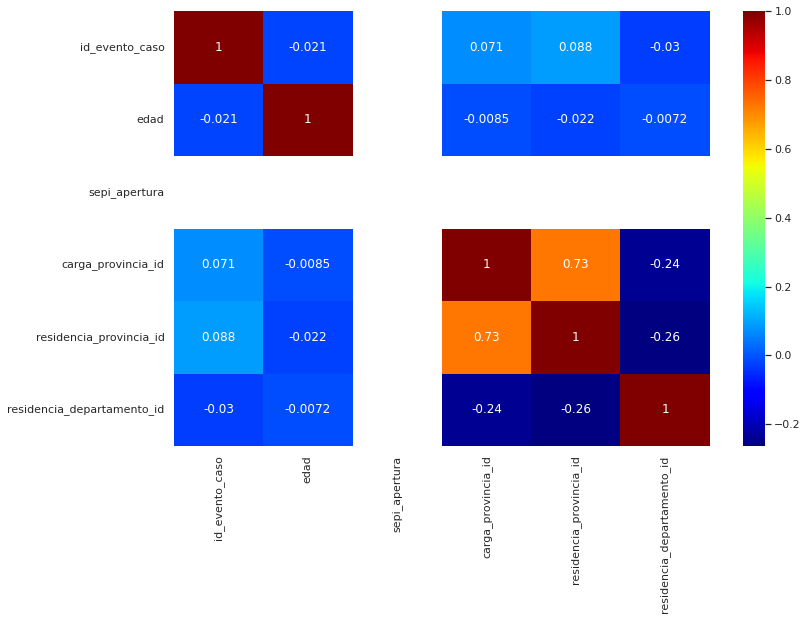

In [ ]:
df_corre = df.corr()

plt.figure(figsize=(12, 8))

sns.heatmap(df_corre, xticklabels=df_corre.columns.values, yticklabels=df_corre.columns.values, annot=True, cmap='jet')

Se puede observar como existe una correlación entre residencia_provincia_id y carga_provincia_id algo bastante rezonable en el sentido de que la provincia en donde se carga la el dato es la provincia de origen del contagiado.

#### Dependencias categóricas vs categóricas

##### Depencia entre las variables sexo y cuidado_intensivo

In [ ]:
ct = pd.crosstab(df['sexo'], df['cuidado_intensivo'])

ct

cuidado_intensivo     NO   SI
sexo                         
F                  52459  204
M                  46298  297
NR                   732   10

In [ ]:
ct = pd.crosstab(df['sexo'], df['cuidado_intensivo'], normalize=True)*100 

ct

cuidado_intensivo      NO     SI
sexo                            
F                  52.459  0.204
M                  46.298  0.297
NR                  0.732  0.010

##### Prueba de Chi cuadrado para dependencia

Para poder llegar a un conclusión de la relación entre las variables se va a utilizar la prueba de Chi cuadrado, además se plantea la hipótesis nula a validar y la alternativa. Luego se evalua el p valor obtenido de la prueba de Chi cuadrado y se llega a una conclución.

In [ ]:
# Prueba de Chi cuadrado de independencia
c, p, dof, expected = chi2_contingency(ct) 

# Se imprime el p valor
print(p)

0.9798576874162308


**Ho: Sexo y si recibio cuidados intensivos son independientes**

**Ha: Sexo y si recibio cuidados intensivos son dependientes**

El p valor es muy cercano a 1.0 lo que indica que podemos aceptar la HO a 95% de confianza. Entonces hay independencias entre estas dos variables.

##### Depencia entre las variables sexo y carga_provincia_nombre

In [ ]:
ct1 = pd.crosstab(df['sexo'], df['carga_provincia_nombre'])

ct1.T

sexo                        F      M   NR
carga_provincia_nombre                   
Buenos Aires            15911  14067  379
CABA                    14733  12711  192
Catamarca                 375    338    3
Chaco                     867    719   11
Chubut                    441    444    9
Corrientes               1603   1546    0
Córdoba                  5321   4541   12
Entre Ríos                674    527   10
Formosa                   343    521    1
Jujuy                     171    236    3
La Pampa                  647    497   12
La Rioja                  285    242    6
Mendoza                  2124   1894   24
Misiones                  114    115    0
Neuquén                   325    310    4
Río Negro                 407    343    5
Salta                     681    531    7
San Juan                  456    424   10
San Luis                 1742   1573    0
Santa Cruz                349    513    3
Santa Fe                 2527   2150   19
Santiago del Estero       376    370    8
Tierra del Fuego          115    120    0
Tucumán                  2076   1863   24

Se calcula los valores relativos de la tabla cruzada.

In [ ]:
ct1 = pd.crosstab(df['sexo'], df['carga_provincia_nombre'], normalize=True)*100 

ct1.T

sexo                         F       M     NR
carga_provincia_nombre                       
Buenos Aires            15.911  14.067  0.379
CABA                    14.733  12.711  0.192
Catamarca                0.375   0.338  0.003
Chaco                    0.867   0.719  0.011
Chubut                   0.441   0.444  0.009
Corrientes               1.603   1.546  0.000
Córdoba                  5.321   4.541  0.012
Entre Ríos               0.674   0.527  0.010
Formosa                  0.343   0.521  0.001
Jujuy                    0.171   0.236  0.003
La Pampa                 0.647   0.497  0.012
La Rioja                 0.285   0.242  0.006
Mendoza                  2.124   1.894  0.024
Misiones                 0.114   0.115  0.000
Neuquén                  0.325   0.310  0.004
Río Negro                0.407   0.343  0.005
Salta                    0.681   0.531  0.007
San Juan                 0.456   0.424  0.010
San Luis                 1.742   1.573  0.000
Santa Cruz               0.349   0.513  0.003
Santa Fe                 2.527   2.150  0.019
Santiago del Estero      0.376   0.370  0.008
Tierra del Fuego         0.115   0.120  0.000
Tucumán                  2.076   1.863  0.024

##### Prueba de Chi cuadrado para dependencia

Para poder llegar a un conclusión de la relación entre las variables se va a utilizar la prueba de Chi cuadrado, además se plantea la hipótesis nula a validar y la alternativa. Luego se evalua el p valor obtenido de la prueba de Chi cuadrado y se llega a una conclución.

In [ ]:
# Prueba de Chi cuadrado de independencia
c, p, dof, expected = chi2_contingency(ct1) 

# Se imprime el p valor
print(p)

1.0


**Ho: Sexo y la provincia de carga son independientes**

**Ha: Sexo y la provincia de carga son dependientes**

El p valor es de 1.0 lo que indica que podemos aceptar la HO a 95% de confianza. Entonces hay independencias entre estas dos variables.

#### Dependencias categóricas vs numéricas

Para llevar a cabo éste análisis se procede al análisis gráfico de los boxplots de las variables concideradas. Para el caso se analiza el cálculo de la medianas de las edades.

##### Depencia entre las variables edad y cuidado_intensivo

<AxesSubplot:xlabel='edad', ylabel='cuidado_intensivo'>

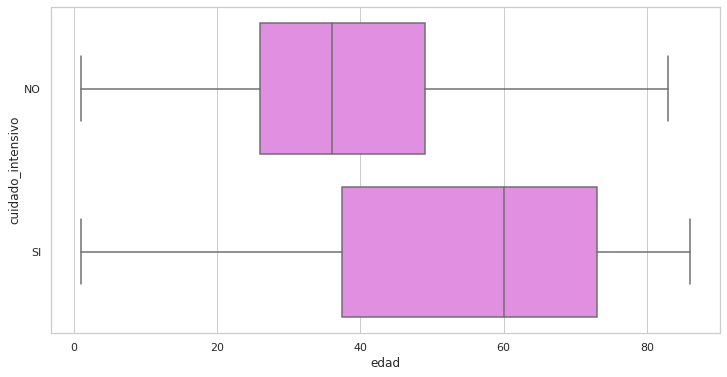

In [ ]:
plt.figure(figsize=(12, 6))

sns.boxplot(x='edad', y='cuidado_intensivo', data=df, showfliers=False, color='violet')

In [ ]:
df.groupby(by='cuidado_intensivo').median()['edad']

cuidado_intensivo
NO    36.0
SI    60.0
Name: edad, dtype: float64

Del análisis de la gráfica y del calculo de la median se desprende que las personas con menos edad no necesitaron de cuidados intensivos.

##### Depencia entre las variables edad y sexo

<AxesSubplot:xlabel='edad', ylabel='sexo'>

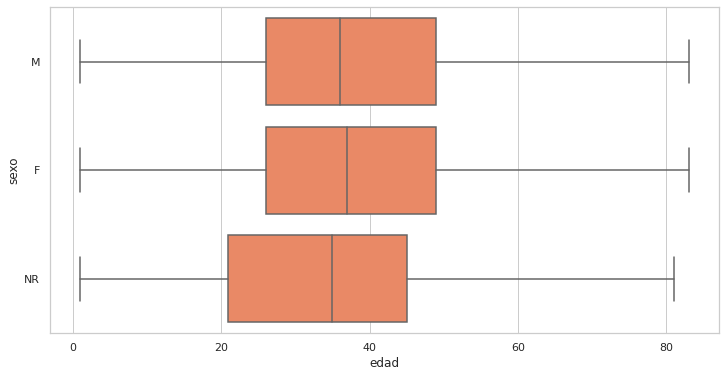

In [ ]:
plt.figure(figsize=(12, 6))

sns.boxplot(x='edad', y='sexo', data=df, showfliers=False, color='coral')

In [ ]:
df.groupby(by='sexo').median()['edad']

sexo
F     37.0
M     36.0
NR    35.0
Name: edad, dtype: float64

Se puede observar del gráfico y del cálculo de la mediana que la edad es basante parecida para la variable sexo, lo que indica que el sexo no influye en la edad de los contagiados.

##### Depencia entre las variables edad y carga_provincia_nombre

<AxesSubplot:xlabel='edad', ylabel='carga_provincia_nombre'>

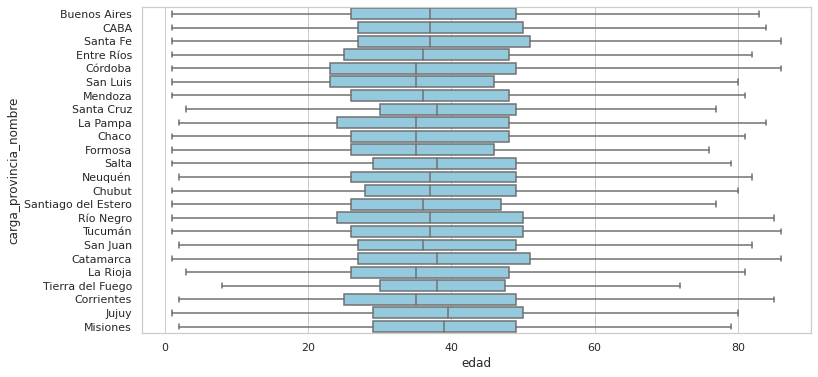

In [ ]:
plt.figure(figsize=(12, 6))

sns.boxplot(x='edad', y='carga_provincia_nombre', data=df, showfliers=False, color='skyblue')

In [ ]:
df.groupby(by='carga_provincia_nombre').median()['edad']

carga_provincia_nombre
Buenos Aires           37.0
CABA                   37.0
Catamarca              38.0
Chaco                  35.0
Chubut                 37.0
Corrientes             35.0
Córdoba                35.0
Entre Ríos             36.0
Formosa                35.0
Jujuy                  39.5
La Pampa               35.0
La Rioja               35.0
Mendoza                36.0
Misiones               39.0
Neuquén                37.0
Río Negro              37.0
Salta                  38.0
San Juan               36.0
San Luis               35.0
Santa Cruz             38.0
Santa Fe               37.0
Santiago del Estero    36.0
Tierra del Fuego       38.0
Tucumán                37.0
Name: edad, dtype: float64

De la gráfica de boxplots y del cálculo de la medina de la edad para las distintas provincias, se observa que la misma es bastante parecida en todas.

###  Resultado del análisis estadístico

Las conclusiones a las que se llegan son la siguientes:

- La variable edad posee una distribución asimétrica a derecha o positiva.

- La edad muestra valores parecidos cuando se la compara con la distribución de contagiados en las provincias y con respecto al sexo pero si muestra diferencia si se la evalua con respecto a la variable 
cuidados intensivos.

## Encoding de variables categóricas

Se instancia la clase usada para el encoding.

In [ ]:
encoder = LabelEncoder()

Se verifica con que campos se cuenta.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 20 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   id_evento_caso                    100000 non-null  int64  
 1   sexo                              100000 non-null  object 
 2   edad                              100000 non-null  float64
 3   edad_años_meses                   100000 non-null  object 
 4   residencia_pais_nombre            100000 non-null  object 
 5   residencia_provincia_nombre       100000 non-null  object 
 6   residencia_departamento_nombre    100000 non-null  object 
 7   carga_provincia_nombre            100000 non-null  object 
 8   fecha_apertura                    100000 non-null  object 
 9   sepi_apertura                     100000 non-null  float64
 10  cuidado_intensivo                 100000 non-null  object 
 11  fallecido                         100000 non-null  ob

Se crea copia del dataframe original y se utiliza la copia para trabajar.

In [ ]:
df1 = df.copy()

* Se codifican de variables con muchas categorías por medio de Label Encoder.
* Se codifican cada uno de los siguientes campos: residencia_pais_nombre, residencia_provincia_nombre, residencia_departamento_nombre, carga_provincia_nombre, clasificacion, clasificacion_resumen.

In [ ]:
df1['residencia_pais_nombre'] = encoder.fit_transform(df1['residencia_pais_nombre']).astype('int32')
df1['residencia_provincia_nombre'] = encoder.fit_transform(df1['residencia_provincia_nombre']).astype('int32')
df1['residencia_departamento_nombre'] = encoder.fit_transform(df1['residencia_departamento_nombre']).astype('int32')
df1['carga_provincia_nombre'] = encoder.fit_transform(df1['carga_provincia_nombre']).astype('int32')
df1['clasificacion'] = encoder.fit_transform(df1['clasificacion']).astype('int32')
df1['clasificacion_resumen'] = encoder.fit_transform(df1['clasificacion_resumen']).astype('int32')
df1['sexo'] = encoder.fit_transform(df1['sexo']).astype('int32')
df1['fallecido'] = encoder.fit_transform(df1['fallecido']).astype('int32')

* Se codifican las variables con pocas categorías por medio de One Hot Encoder
* Se codifican cada uno de los siguientes campos: sepi_apertura, fallecido, asistencia_respiratoria_mecanica, origen_financiamiento, cuidado_intensivo, edad_años_meses

In [ ]:
df1 = pd.get_dummies(df1, columns=['sepi_apertura', 'asistencia_respiratoria_mecanica', 'origen_financiamiento', 'cuidado_intensivo', 'edad_años_meses'])

* Se eliminan las columnas contrastantes.
* Se eliminan las columnas con referencias a fechas que no son de utilidad en el análisis.
* Se elimina la columna **id_evento_caso** ya que solo es un identificador del registro y no es útil en el análisis.


In [ ]:
df1.drop(columns=['sepi_apertura_14.0', 'asistencia_respiratoria_mecanica_NO', 'origen_financiamiento_Privado', 'cuidado_intensivo_NO', 'edad_años_meses_Años'], inplace=True)  

df1.drop(columns=['fecha_apertura', 'ultima_actualizacion'], inplace=True)  

df1.drop(columns=['id_evento_caso'], inplace=True)  

In [ ]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 15 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   sexo                                 100000 non-null  int32  
 1   edad                                 100000 non-null  float64
 2   residencia_pais_nombre               100000 non-null  int32  
 3   residencia_provincia_nombre          100000 non-null  int32  
 4   residencia_departamento_nombre       100000 non-null  int32  
 5   carga_provincia_nombre               100000 non-null  int32  
 6   fallecido                            100000 non-null  int32  
 7   carga_provincia_id                   100000 non-null  float64
 8   clasificacion                        100000 non-null  int32  
 9   clasificacion_resumen                100000 non-null  int32  
 10  residencia_provincia_id              100000 non-null  float64
 11  residencia_dep

### Resultado de encoding de variables categóricas:
Actualmente se posee un dataset con todas variables numéricas, listo para ser utilizado en algún algoritmo pero antes hay que ver si el dataset no esta desbalanceado.

## Balanceo de las variables de salida(Oversampling)

Como el dataset esta desbalanceado, se realiza el oversampling del dataset para balancear los datos.

In [ ]:
oversample = RandomOverSampler(sampling_strategy='minority')

X = df1.drop(['fallecido'], axis=1) 
y = df1['fallecido'] 

X_over, y_over = oversample.fit_resample(X, y) 

### Se determina los sets de entrenamiento y de test

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, test_size= 0.2, random_state= 42) 

print(y_train.value_counts())
print(y_test.value_counts())

0    79603
1    79389
Name: fallecido, dtype: int64
1    19981
0    19767
Name: fallecido, dtype: int64


### Resultado del balanceo de las variables de salida:
Como se observa ahora los datasets estan balanceados, a contunuación hay que seleccionar la mejor combinación de variables para ser utilizadas en el algoritmo a elegir.

## Selección de las variables a utilizar

Como primera medida se va a declarar una función que me devuelve cuales son las mejores variables a ser utlizadas en el algoritmo que se seleccionará posteriormente.

### Ejecución de la función de selección

Se pasa como parámetro a la función: X, y; para la selección de las variables.

In [ ]:
forward_selection(X, y)

/tmp/ipykernel_10975/468486454.py:54: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.

/tmp/ipykernel_10975/468486454.py:54: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.

/tmp/ipykernel_10975/468486454.py:54: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.

/tmp/ipykernel_10975/468486454.py:54: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.

/tmp/ipykernel_10975/468486454.py:54: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warni

['asistencia_respiratoria_mecanica_SI',
 'edad',
 'cuidado_intensivo_SI',
 'clasificacion_resumen',
 'residencia_departamento_id',
 'origen_financiamiento_Público',
 'sexo',
 'residencia_pais_nombre',
 'residencia_departamento_nombre']

### Resultado de la selección de variables a utilizar:
Con el listado de las variables a utilizar, resta emplearlas en el algoritmo que se ve a usar.

## Selección de los algoritmos a aplicar
Como la variable target es categórica se debe seleccionar un algoritmo de clasificación

Para el presente trabajo se van a utilizar 3 algoritmos de clasificación: KNN, Random Forest y Decision Tree

### **Primer algoritmo: KNN**

Se corre el algoritmo, se calcula el accurary y se grafica la matriz de confusión.

Accuracy: 0.9963268592130422


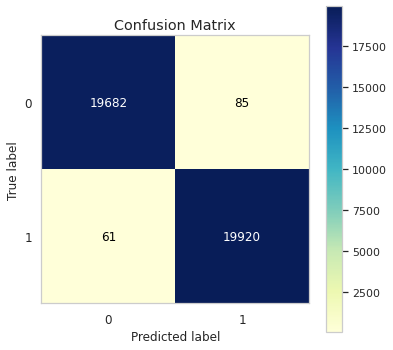

In [ ]:
knn = KNeighborsClassifier(n_neighbors=2) 
knn.fit(X_train, y_train)  
y_pred_knn = knn.predict(X_test) 
y_pred_prob_knn = knn.predict_proba(X_test)[:, 1]

skplt.metrics.plot_confusion_matrix(y_test, y_pred_knn, figsize=(6,6), cmap= 'YlGnBu');

print('Accuracy:', accuracy_score(y_test, y_pred_knn))

### **Segundo algoritmo: Random Forest**

Se corre el algoritmo, se calcula el accurary y se grafica la matriz de confusión.

Accuracy: 0.9989936600583678


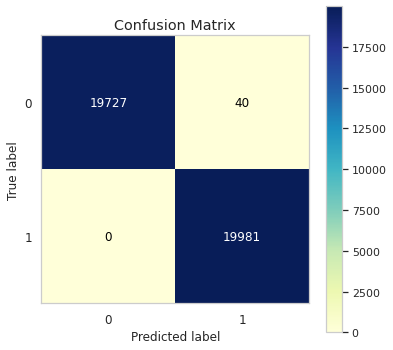

In [ ]:
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train) 
y_pred_rf = rf.predict(X_test) 
y_pred_prob_rf = rf.predict_proba(X_test)[:, 1]

skplt.metrics.plot_confusion_matrix(y_test, y_pred_rf, figsize=(6,6), cmap= 'YlGnBu');
print('Accuracy:', accuracy_score(y_test, y_pred_rf))

### **Tercer algoritmo: Decision Tree**

Se corre el algoritmo, se calcula el accurary y se grafica la matriz de confusión.

Accuracy: 0.9398208714903895


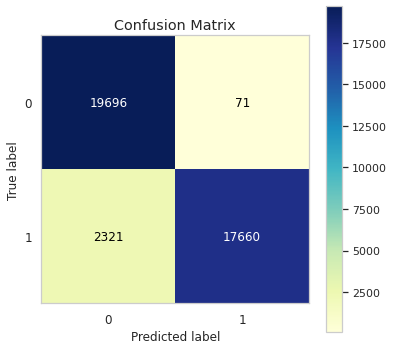

In [ ]:
dtc = DecisionTreeClassifier(criterion='entropy', max_depth=3) 
dtc.fit(X_train, y_train)
y_pred_dtc = dtc.predict(X_test) 
y_pred_prob_dtc = dtc.predict_proba(X_test)[:, 1]

skplt.metrics.plot_confusion_matrix(y_test, y_pred_dtc, figsize=(6,6), cmap= 'YlGnBu');
print('Accuracy:', accuracy_score(y_test, y_pred_dtc))

### Resultado de la selección de los algoritmos a aplicar:
Con los resultados de los accuracy y las matrices de confusión de cada algoritmo solo nos resta realizar los cálculos de las métricas para cada uno de ellos.

## Evaluación de métricas para cada uno de los algoritmos

### **Métricas para KNN**

In [ ]:
print(classification_report(y_test, y_pred_knn)) 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19767
           1       1.00      1.00      1.00     19981

    accuracy                           1.00     39748
   macro avg       1.00      1.00      1.00     39748
weighted avg       1.00      1.00      1.00     39748



### **Métricas para Random Forest**

In [ ]:
print(classification_report(y_test, y_pred_rf)) 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19767
           1       1.00      1.00      1.00     19981

    accuracy                           1.00     39748
   macro avg       1.00      1.00      1.00     39748
weighted avg       1.00      1.00      1.00     39748



### **Métricas para Decision Tree**

In [ ]:
print(classification_report(y_test, y_pred_dtc)) 

              precision    recall  f1-score   support

           0       0.89      1.00      0.94     19767
           1       1.00      0.88      0.94     19981

    accuracy                           0.94     39748
   macro avg       0.95      0.94      0.94     39748
weighted avg       0.95      0.94      0.94     39748



### Resultado del cálculo de métricas para cada uno de los algoritmos

Como se puede observar de la métricas, los mejores resultados se los obtiene KNN y de Random Forest pero lo que llama la atención es que los mismos tiene un 100 % de probabilidad en todas las métricas, habria que revisar hasta que punto con menos variables siguen teniendo ese rendimiento, ya que podría darse un caso de overfitting. Para el caso de árboles de desición se observa que el mismo tiene un rendimiento más pobre.